# Studi Pemecahan Persamaan Difusi Menggunakan Metode Deep Learning

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import metrics

## Read data

Data diperoleh dari penyelesaian persamaan difusi menggunakan metode beda hingga dengan skema FTCS. Data ini akan digunakan dalam proses training dari neural network

In [2]:
datafile = open("diffusiondata.csv", 'r')

In [3]:
ori_df = pd.read_csv("diffusiondata.csv", index_col='i')
df = ori_df.copy()
ori_df

,t,x,"u(t, x)"
i,,,
0,0.000,0.000000,0.000000
1,0.000,0.040816,0.063939
2,0.000,0.081633,0.127614
3,0.000,0.122449,0.190766
4,0.000,0.163265,0.253133
...,...,...,...
49995,1.998,1.836735,0.032435
49996,1.998,1.877551,0.024444
49997,1.998,1.918367,0.016352


In [4]:
# pemisahan target dan features
target = df.pop('u(t, x)')
features = df.to_numpy()

Target : u

Features : t, x

## Scaling layer

Karena perbedaan skala dari target dan features, dilakukan scaling agar membantu proses training neural network

In [5]:
from sklearn.preprocessing import MinMaxScaler

targetScaler = MinMaxScaler()
featuresScaler = MinMaxScaler()
scaled_target = targetScaler.fit_transform(target.to_numpy().reshape(-1,1))
scaled_features = featuresScaler.fit_transform(features)
scaled_target_df = pd.DataFrame(scaled_target, columns=['u(t, x)'])
scaled_features_df = pd.DataFrame(scaled_features, columns=df.columns)

Kemudian, data di shuffle dan dipisah menjadi training set dan testing set

In [6]:
full_dataset = tf.data.Dataset.from_tensor_slices((scaled_features_df.values, scaled_target_df.values))
unshuffled_dataset = full_dataset.batch(1)

full_dataset = full_dataset.shuffle(len(df)).batch(1)

In [7]:
test_dataset = full_dataset.take(tf.data.experimental.cardinality(full_dataset).numpy()*.2)
train_dataset = full_dataset.skip(tf.data.experimental.cardinality(full_dataset).numpy()*.2)

## Inisialisasi model

Digunakan neural network dengan jumlah hidden layer 3 dan jumlah neuron tiap layer 20

In [8]:
def getModel():
    tf.keras.backend.set_floatx('float64')
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),
        tf.keras.layers.Dense(20, activation='sigmoid'),
        tf.keras.layers.Dense(20, activation='sigmoid'),
        tf.keras.layers.Dense(20, activation='sigmoid'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss='mse',
                 metrics=['mae', 'mse'])
    return model

In [9]:
model = getModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 921
Trainable params: 921
Non-trainable params: 0
_________________________________________________________________


## Training model

In [12]:
history = model.fit(train_dataset, validation_data=test_dataset, batch_size=64, epochs=10)

loss, mae, mse = model.evaluate(test_dataset, verbose=2)

Epoch 1/10
40000/40000 [==============================] - 181s 4ms/step - loss: 0.0271 - mae: 0.1246 - mse: 0.0271 - val_loss: 0.0270 - val_mae: 0.1189 - val_mse: 0.0270
Epoch 2/10
40000/40000 [==============================] - 171s 4ms/step - loss: 0.0253 - mae: 0.1201 - mse: 0.0253 - val_loss: 0.0250 - val_mae: 0.1158 - val_mse: 0.0250
Epoch 3/10
40000/40000 [==============================] - 171s 4ms/step - loss: 0.0251 - mae: 0.1198 - mse: 0.0251 - val_loss: 0.0238 - val_mae: 0.1172 - val_mse: 0.0238
Epoch 4/10
40000/40000 [==============================] - 172s 4ms/step - loss: 0.0245 - mae: 0.1182 - mse: 0.0245 - val_loss: 0.0196 - val_mae: 0.1054 - val_mse: 0.0196
Epoch 5/10
40000/40000 [==============================] - 171s 4ms/step - loss: 0.0059 - mae: 0.0494 - mse: 0.0059 - val_loss: 0.0011 - val_mae: 0.0243 - val_mse: 0.0011
Epoch 6/10
40000/40000 [==============================] - 192s 5ms/step - loss: 9.3133e-04 - mae: 0.0225 - mse: 9.3133e-04 - val_loss: 5.2789e-04 - va

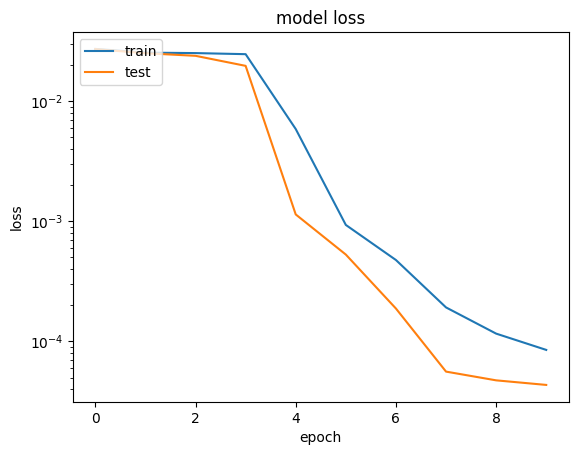

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
plt.show()

Kita prediksi tiap titik yang telah ditentukan menggunakan model deep learning yang sudah di train, tidak lupa untuk mengembalikannya ke skala awal

In [15]:
x = np.linspace(0, 2, 500)
t = ori_df['t'].unique()
xmesh, tmesh = np.meshgrid(x,t)
X = np.vstack((np.ravel(tmesh), np.ravel(xmesh))).T
scaledX = featuresScaler.transform(X)
scaled_predictions = model.predict(scaledX)
predictions = targetScaler.inverse_transform(scaled_predictions)

15625/15625 [==============================] - 25s 2ms/step


## Solusi analitik

In [16]:
def diff_eq_exact_solution(x, t):
    alpha = 0.4
    return np.exp(-(np.pi**2 * alpha * t / 4)) * np.sin(np.pi * x / 2)

## Perbandingan tiap metode

Plot grafik perbandingan antar metode

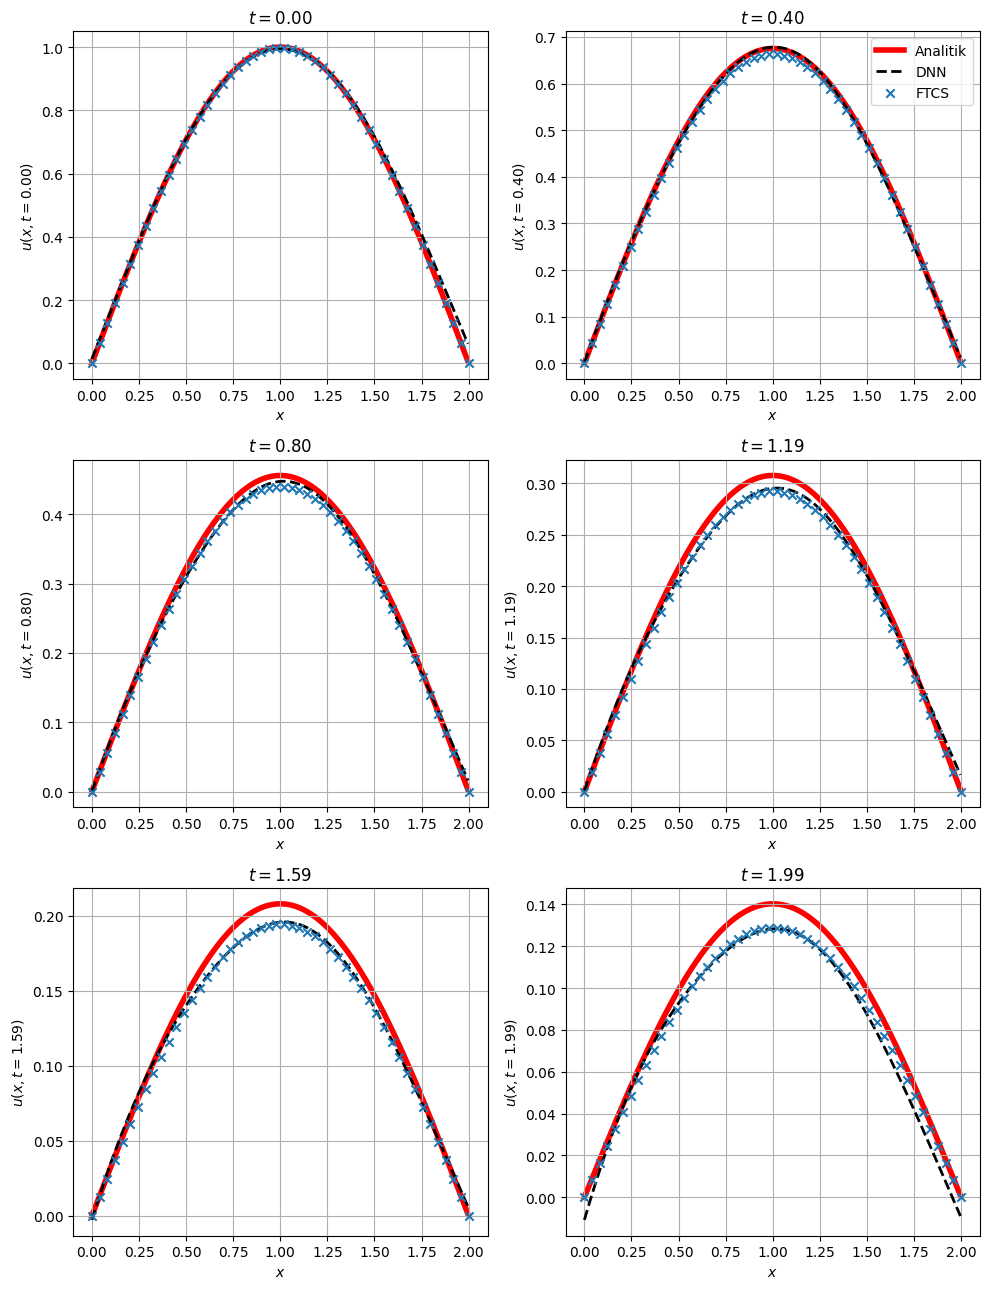

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(10,13))
figTime = 0
# fig.suptitle("Metode Analitik (Separasi Variabel)")
for ax in axs.flat:
    ax.grid()
    ax.set(xlabel='$x$', ylabel='$u(x, t = {:.2f})$'.format(t[figTime]))
#     ax.set_ylim([-.1, 1.1])
    start = np.where(X[:, 0] == t[figTime])[0][0]
    end = np.where(X[:, 0] == t[figTime])[0][-1]
    markersize = [20 for i in range(50)]
    ax.plot(X[start:end, 1], diff_eq_exact_solution(X[start:end, 1], t[figTime]), 'r-', linewidth=4, label = 'Analitik', zorder = 0)
    ax.plot(X[start:end, 1], predictions[start:end], 'k--', linewidth=2, label = 'DNN', zorder = 5)
    ax.scatter(ori_df.loc[ori_df['t'] == t[figTime]]['x'], ori_df.loc[ori_df['t'] == t[figTime]]['u(t, x)'], marker='x', label = 'FTCS', zorder = 10)
    ax.set_title("$t = {:.2f}$".format(t[figTime]))
    figTime += 199

axs[0,1].legend()

plt.tight_layout()
plt.savefig("DLDiffEq.png", dpi=300)

Nilai puncak dan MSE dari tiap metode

In [18]:
from sklearn.metrics import mean_squared_error as MSE
print('\033[1m' + "Method         Peak                   MSE" + '\033[0m' +
      "\nAnalytic      ", diff_eq_exact_solution(X[:, 1], X[:, 0]).max(),
      "\nFTCS          ", ori_df['u(t, x)'].max(),"   ", MSE(ori_df['u(t, x)'].to_numpy(), diff_eq_exact_solution(ori_df['x'].to_numpy(),ori_df['t'].to_numpy())),
      "\nDNN           ", predictions.max(),"   ", MSE(predictions, diff_eq_exact_solution(X[:, 1], X[:, 0]))
     )

Method         Peak                   MSE
Analytic       0.9999950454033061 
FTCS           0.9974326645749432     8.829739842791249e-05 
DNN            0.9946441543467308     7.099656993684352e-05
